In [89]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Exploring COVID-19 Data through Modeling


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [90]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [91]:
#impute null values for cases dataset
cases = cases.fillna(0)
#impute null values for vaccinations
vaccinations = vaccinations.fillna(0)
#impute null values for counties
counties = counties.fillna(0)
#impute null values for mask_use
mask_use = mask_use.fillna(0)

In [92]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [93]:
counties['FIPS'] = counties['STATE']*1000 + counties['COUNTY']
counties

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,POPESTIMATE042020,POPESTIMATE2020,FIPS
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,4831586,4843737,4854803,4866824,4877989,4891628,4907965,4920706,4921532,1000
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,54747,54922,54903,55302,55448,55533,55769,56130,56145,1001
2,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,194978,199306,203101,207787,212737,218071,223565,227989,229287,1003
3,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,26946,26768,26300,25828,25169,24887,24657,24652,24589,1005
4,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,22510,22541,22553,22590,22532,22300,22313,22199,22136,1007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,45189,44996,44780,44319,43663,43188,42917,42717,42673,56037
3190,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,22335,22801,23083,23255,23383,23261,23385,23453,23497,56039
3191,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,20969,20835,20777,20711,20449,20299,20196,20169,20215,56041
3192,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,8417,8277,8282,8180,8013,7886,7824,7756,7760,56043


In [94]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [95]:
county_data = counties.merge(cases)
county_data = county_data.merge(mask_use, right_on = "COUNTYFP", left_on = "FIPS")
county_data

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,9/9/21,9/10/21,9/11/21,9/12/21,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,9145,9207,9246,9287,1001,0.053,0.074,0.134,0.295,0.444
1,50,3,6,1,3,Alabama,Baldwin County,182265,182263,183121,...,34536,34726,34872,34950,1003,0.083,0.059,0.098,0.323,0.436
2,50,3,6,1,5,Alabama,Barbour County,27457,27454,27325,...,3243,3260,3282,3295,1005,0.067,0.121,0.120,0.201,0.491
3,50,3,6,1,7,Alabama,Bibb County,22915,22904,22858,...,3727,3752,3778,3795,1007,0.020,0.034,0.096,0.278,0.572
4,50,3,6,1,9,Alabama,Blount County,57322,57322,57372,...,9048,9095,9161,9176,1009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,50,4,8,56,37,Wyoming,Sweetwater County,43806,43806,43580,...,6034,6111,6111,6111,56037,0.061,0.295,0.230,0.146,0.268
3137,50,4,8,56,39,Wyoming,Teton County,21294,21298,21298,...,4587,4611,4611,4611,56039,0.095,0.157,0.160,0.247,0.340
3138,50,4,8,56,41,Wyoming,Uinta County,21118,21121,21090,...,3168,3204,3204,3204,56041,0.098,0.278,0.154,0.207,0.264
3139,50,4,8,56,43,Wyoming,Washakie County,8533,8528,8531,...,1111,1120,1120,1120,56043,0.204,0.155,0.069,0.285,0.287


In [96]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

,9/12/21,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
9/12/21,1.000000,-0.174157,-0.189829,-0.181213,-0.137103,0.262421
NEVER,-0.174157,1.000000,0.427804,0.322870,0.050347,-0.684537
RARELY,-0.189829,0.427804,1.000000,0.364388,0.144175,-0.728177
SOMETIMES,-0.181213,0.322870,0.364388,1.000000,0.073865,-0.668884
FREQUENTLY,-0.137103,0.050347,0.144175,0.073865,1.000000,-0.517932
ALWAYS,0.262421,-0.684537,-0.728177,-0.668884,-0.517932,1.000000


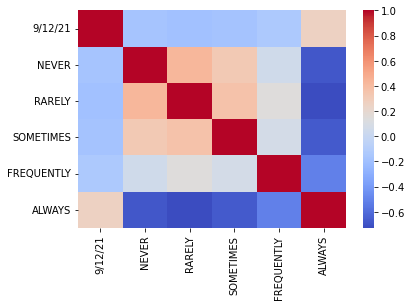

In [97]:
county_corr = county_data[['9/12/21', 'NEVER','RARELY','SOMETIMES','FREQUENTLY','ALWAYS']].corr()
sns.heatmap(county_corr, cmap='coolwarm')
county_corr

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [98]:
X_q5b = county_data[['NEVER','RARELY','SOMETIMES','FREQUENTLY', 'ALWAYS']]
y_q5b = county_data['9/12/21']

#Make sure to set random_state = 42 and test_size = 0.33!
#perform train test dataset split
X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test = train_test_split(X_q5b, y_q5b, test_size=0.33, random_state=42) 

#fit and predict using train data
model = LinearRegression(fit_intercept =  True)
model.fit(X_q5b_train, y_q5b_train)
y_fitted = model.predict(X_q5b_train)

#predict using test
y_predicted = model.predict(X_q5b_test)

#create train and test rmse
train_rmse_cases = np.sqrt(np.mean((y_fitted - y_q5b_train)**2))
test_rmse_cases = np.sqrt(np.mean((y_predicted - y_q5b_test)**2))

train_rmse_cases, test_rmse_cases

(27834.430707426982, 62591.13087482178)

In [99]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

The test set RMSE may be much higher than the training set RMSE since the model may be overfitting on the training data and is not able to generalize and predict as well for the test set. Overfitting may occur when there are too many irrelevant features or not enough training data. 

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [100]:
X_q5d = county_data[['NEVER','RARELY','SOMETIMES','FREQUENTLY', 'ALWAYS']]
y_q5d = county_data['9/12/21']/county_data['POPESTIMATE2020']

#perform train test dataset split
X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = train_test_split(X_q5d, y_q5d, test_size=0.33, random_state=42) 

#fit and predict using train data
model = LinearRegression(fit_intercept =  True)
model.fit(X_q5d_train, y_q5d_train)
y_fitted = model.predict(X_q5d_train)

#predict using test data
y_predicted = model.predict(X_q5d_test)

#create train and test rmse
train_rmse_cpc = np.sqrt(np.mean((y_fitted - y_q5d_train)**2))
test_rmse_cpc = np.sqrt(np.mean((y_predicted - y_q5d_test)**2))

train_rmse_cpc, test_rmse_cpc

(0.03540985737823185, 0.038167903498916037)

In [101]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

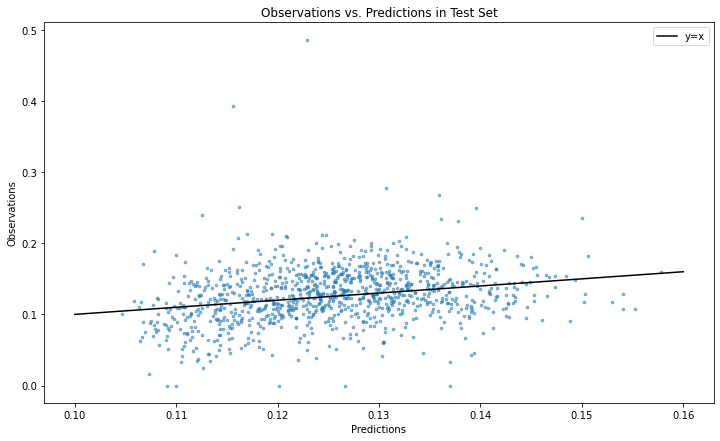

In [102]:
plt.figure(figsize=(12, 7))
plt.scatter(y_predicted, y_q5d_test, s=7, alpha=0.5)
x = np.arange(0.1, 0.161, 0.01)
y = np.arange(0.1, 0.161, 0.01)
plt.plot(x, y, label='y=x', color='black')
plt.legend()
plt.title('Observations vs. Predictions in Test Set')
plt.xlabel('Predictions')
plt.ylabel('Observations');


# This plot indicates that our linear model is a decent fit for the test set.
# If the model was a perfect fit, all points would be on the black y=x line.
# Since this line cuts through our data quite well, we can say that the model is definitely on the right track. 
# However, there is still quite a bit of noise and variance since the actual data points lie above and below the line. 

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [103]:
models = [] 

#combining X and y in preparation for sampling
df_X_y_q5d = pd.concat([X_q5d_train, y_q5d_train], axis=1)

for i in range(1000): 
    #sampling from the combined dataframe with replacement
    bootstrapped_df_q5d = df_X_y_q5d.sample(frac=1, replace=True)
    #splitting up X and y after sampling
    bootstrapped_X = bootstrapped_df_q5d[['NEVER','RARELY','SOMETIMES','FREQUENTLY', 'ALWAYS']]
    bootstrapped_y = bootstrapped_df_q5d[0]

    #fit using bootstrapped X and y
    model = LinearRegression(fit_intercept=True)
    model.fit(bootstrapped_X, bootstrapped_y)
    models.append(model)

In [104]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [105]:
# i=100 testing point
test_point_x, test_point_y = X_q5d_test.iloc[[100]], y_q5d_test.iloc[100]

predictions = []
losses = []

for i in np.arange(1000): 
    #prediction and loss for each model
    y_predicted = models[i].predict(test_point_x)
    loss = (test_point_y - y_predicted)**2
    
    predictions.append(y_predicted)
    losses.append(loss)
    
variance  = np.var(predictions)
expectation = np.mean(losses)
    
prop_var = variance / expectation
prop_var

0.0012800059352967305

In [106]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

_
1) We know that model risk = observation + (model bias) ^ 2 + model variance. If there is no observational noise, then we know that both the bias ^2 and variance must equal the model risk. From our previous decomposition, variance does not contribute signficantly to the error. Therefore, the magnitude of the empirical model bias will be large and significant. 

2) Observational noise plays a signficant role within a real-life example like COVID-19. For example, different counties have different levels of testing, so the number of cases may be higher/lower depending on how often a county performs testing. Furthermore, the article states that "number of detected cases in the United States could underestimate the true number of infected people by anywhere from a multiple of two times to 100 times." Furthermore, the article discusses how there are 30% asymptomatic cases which aligns with medical literature but can add additional noise to out data set. 

3) In our theoretical case, we assumed that u = 0 because noise has an equally likely chance of either overestimate or understimate the true result g(x). For example, if taken an infinite number of  samples, we should expect noise to cancel out since there will be situations where epsilon is positive and situations where epsilon is negative. However, from the previous article, we saw that the number of detected cases is an underestimate and that the true value (g(x)) is somewhere much higher. Therefore, a more appropriate mean would then be a negative value as that suggests that our observational noise epsilon tends to be negative. If we then do Y + epsilon, then we will get our true value of g(x). 

4) The standard decomposition no longer holds because the E[epsilon] no longer equates to 0 because it is normally distributed. In order to make it again valid, we must modify epsilon so that it becomes a random variable. In order to do so, we can express y = g(x) + epsilon and then subtract an additional term delta (y = g(x) + epsilon - delta) where delta is a normal variable. By subtracting delta, we cancel out the normal variables and we can then create a random variable. 

5) It is possible to minimize the true model bias to be zero in the finite case. This will occur if E(Y(X))= g(x) and the resulting difference then cancels out to 0. This can occur if our expected value and true value lines up exactly. 

6) In the infite case, it is also possible to minimize the true model bias to be zero because E(Y(X)) can equal g(x). The result difference cancels out to 0 but this is an extremely unlikely scenario. 



_

<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [107]:
predictions_df = pd.DataFrame()

for i in np.arange(1000): 
    #storing all predictions for each of the 1037 test points for each of the 1000 models in a 1037x1000 dataframe 
    y_predicted = models[i].predict(X_q5d_test)
    predictions_df[i] = y_predicted
    
#calculate variances and loss expectations for each test point across all models    
variances = predictions_df.var(axis=1)
loss_expectations = [np.mean((y_q5d_test.iloc[i] - predictions_df.iloc[i])**2) for i in np.arange(len(y_q5d_test))]

avg_var, avg_mse = np.mean(variances), np.mean(loss_expectations)

avg_var, avg_mse

(3.956439792367775e-06, 0.001460637747284272)

In [108]:
grader.check("q5i")

q5i results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

_ From our graphs in part e and numerical values in 5i and 5g, our variance comprises a small fraction of our entire model risk. We also know that variance and bias tends to be inversely related. When variance is small, we know that the bias is very large. In order to minimize the overall error, we need to find the ideal middle spot between variance and bias. 

In order to reduce the mean square error, we then need to increase variance and lower the amount of total bias. This can be achie
._

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

In [109]:
# Using county-wide 2020 presidential election results to label each county with a political party
county_pres = pd.read_csv('data/countypres_2000-2020.csv') #https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VOQCHQ

county_party = county_pres.loc[county_pres[county_pres['year'] == 2020].groupby('county_fips')['candidatevotes'].idxmax()][['county_fips', 'party']]
county_party = county_party.rename({'county_fips':'COUNTYFP'}, axis=1)

county_data_party = county_data.merge(county_party, on = "COUNTYFP")

# Cases per capita
dates = county_data_party.filter(like='/').columns
for date in dates:
    county_data_party[date] = county_data_party[date]/county_data_party['POPESTIMATE2020']

county_data_party = county_data_party.drop(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'CENSUS2010POP', 'ESTIMATESBASE2010', 
                                            'POPESTIMATE2010', 'POPESTIMATE2011', 'POPESTIMATE2012', 'POPESTIMATE2013', 'POPESTIMATE2014',
                                           'POPESTIMATE2015', 'POPESTIMATE2016', 'POPESTIMATE2017', 'POPESTIMATE2018', 'POPESTIMATE2019',
                                           'POPESTIMATE2020', 'POPESTIMATE042020', 'FIPS', 'UID', 'iso2', 'iso3', 'code3', 'Admin2', 
                                            'Province_State', 'Country_Region', 'Combined_Key'], axis=1)
county_data_party['PARTY'] = (county_data_party['party'] == 'DEMOCRAT').astype(int)
county_data_party

,STNAME,CTYNAME,Lat,Long_,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/11/21,9/12/21,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,party,PARTY
0,Alabama,Autauga County,32.539527,-86.644082,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164681,0.165411,1001,0.053,0.074,0.134,0.295,0.444,REPUBLICAN,0
1,Alabama,Baldwin County,30.727750,-87.722071,0.0,0.0,0.0,0.0,0.0,0.0,...,0.152089,0.152429,1003,0.083,0.059,0.098,0.323,0.436,REPUBLICAN,0
2,Alabama,Barbour County,31.868263,-85.387129,0.0,0.0,0.0,0.0,0.0,0.0,...,0.133474,0.134003,1005,0.067,0.121,0.120,0.201,0.491,REPUBLICAN,0
3,Alabama,Bibb County,32.996421,-87.125115,0.0,0.0,0.0,0.0,0.0,0.0,...,0.170672,0.171440,1007,0.020,0.034,0.096,0.278,0.572,REPUBLICAN,0
4,Alabama,Blount County,33.982109,-86.567906,0.0,0.0,0.0,0.0,0.0,0.0,...,0.158278,0.158538,1009,0.053,0.114,0.180,0.194,0.459,REPUBLICAN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3108,Wyoming,Sweetwater County,41.659439,-108.882788,0.0,0.0,0.0,0.0,0.0,0.0,...,0.143205,0.143205,56037,0.061,0.295,0.230,0.146,0.268,REPUBLICAN,0
3109,Wyoming,Teton County,43.935225,-110.589080,0.0,0.0,0.0,0.0,0.0,0.0,...,0.196238,0.196238,56039,0.095,0.157,0.160,0.247,0.340,DEMOCRAT,1
3110,Wyoming,Uinta County,41.287818,-110.547578,0.0,0.0,0.0,0.0,0.0,0.0,...,0.158496,0.158496,56041,0.098,0.278,0.154,0.207,0.264,REPUBLICAN,0
3111,Wyoming,Washakie County,43.904516,-107.680187,0.0,0.0,0.0,0.0,0.0,0.0,...,0.144330,0.144330,56043,0.204,0.155,0.069,0.285,0.287,REPUBLICAN,0


In [128]:
#Pivot table with vaccination rate per state per date
vax_date_state = pd.pivot_table(vaccinations, values='People_Fully_Vaccinated', index='Province_State', columns='Date', fill_value=0)
state_pop = county_data.groupby('STNAME')['POPESTIMATE2020'].sum()
vaxrate_date_state = vax_date_state.merge(state_pop, left_index=True, right_on='STNAME')
vax_dates = vax_date_state.columns
for date in vax_dates:
    vaxrate_date_state[date] = vaxrate_date_state[date]/vaxrate_date_state['POPESTIMATE2020']

vaxrate_date_state = vaxrate_date_state.drop('POPESTIMATE2020', axis=1)
vaxrate_date_state.head()

,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,...,2021-09-17,2021-09-18,2021-09-19,2021-09-20,2021-09-21,2021-09-22,2021-09-23,2021-09-24,2021-09-25,2021-09-26
STNAME,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.408596,0.409024,0.411205,0.412503,0.414230,0.415312,0.415569,0.416412,0.418759,0.420403
Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.504340,0.504340,0.504340,0.508393,0.508598,0.513012,0.515061,0.516705,0.516705,0.516705
Arizona,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.491489,0.492333,0.493256,0.494070,0.494732,0.495403,0.496327,0.497095,0.497944,0.498904
Arkansas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.440979,0.442441,0.444163,0.444902,0.445414,0.446958,0.448164,0.449112,0.450046,0.451211
California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.593025,0.594172,0.595404,0.595955,0.597799,0.599204,0.600330,0.601459,0.602636,0.603279


In [130]:
#county_data_party = county_data_party.merge(vaxrate_date_state['2021-09-26'], left_on='STNAME', right_index=True)
#county_data_party 

In [131]:
#Logistic Regression model with mask usage as inputs and political party as prediction.
X = county_data_party[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS']]
Y = county_data_party['PARTY']

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
print(f"Training Data Size: {len(x_train)}")
print(f"Test Data Size: {len(x_test)}")

lr = LogisticRegression()
lr.fit(x_train, y_train)
train_accuracy = np.mean(y_train == lr.predict(x_train))
test_accuracy = np.mean(y_test == lr.predict(x_test))

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Training Data Size: 2334
Test Data Size: 779
Train accuracy: 0.8432
Test accuracy: 0.8524


In [113]:
#Importance of each feature using coefficients.
pd.DataFrame(data=lr.coef_, index=['Coefficients'], columns=['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS'])

,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
Coefficients,-2.000009,-2.030086,-2.337286,0.296215,6.05778


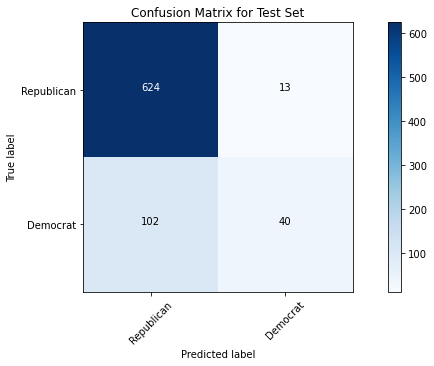

In [114]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, lr.predict(x_test))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['Republican', 'Democrat']
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,5))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix for Test Set')

In [115]:
# Precision and Recall
y_pred = lr.predict(x_test) 
tp = np.sum((y_pred == 1) & (y_test == 1))
fp = np.sum((y_pred == 1) & (y_test == 0))
fn = np.sum((y_pred == 0) & (y_test == 1))

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print(f'precision = {precision:.4f}')
print(f'recall = {recall:.4f}')

precision = 0.7547
recall = 0.2817


In [116]:
#Placing the predictions in our dataframe to be used as a feature in the next model.
county_data_party['Predicted Party'] = lr.predict(X)
county_data_party['Predicted Party Name'] =  county_data_party['Predicted Party']
mapping = {0: "REPUBLICAN", 1: "DEMOCRAT"}
county_data_party['Predicted Party Name'].replace(mapping, inplace=True)
county_data_party.head()

,STNAME,CTYNAME,Lat,Long_,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,party,PARTY,Predicted Party,Predicted Party Name
0,Alabama,Autauga County,32.539527,-86.644082,0.0,0.0,0.0,0.0,0.0,0.0,...,1001,0.053,0.074,0.134,0.295,0.444,REPUBLICAN,0,0,REPUBLICAN
1,Alabama,Baldwin County,30.727750,-87.722071,0.0,0.0,0.0,0.0,0.0,0.0,...,1003,0.083,0.059,0.098,0.323,0.436,REPUBLICAN,0,0,REPUBLICAN
2,Alabama,Barbour County,31.868263,-85.387129,0.0,0.0,0.0,0.0,0.0,0.0,...,1005,0.067,0.121,0.120,0.201,0.491,REPUBLICAN,0,0,REPUBLICAN
3,Alabama,Bibb County,32.996421,-87.125115,0.0,0.0,0.0,0.0,0.0,0.0,...,1007,0.020,0.034,0.096,0.278,0.572,REPUBLICAN,0,0,REPUBLICAN
4,Alabama,Blount County,33.982109,-86.567906,0.0,0.0,0.0,0.0,0.0,0.0,...,1009,0.053,0.114,0.180,0.194,0.459,REPUBLICAN,0,0,REPUBLICAN


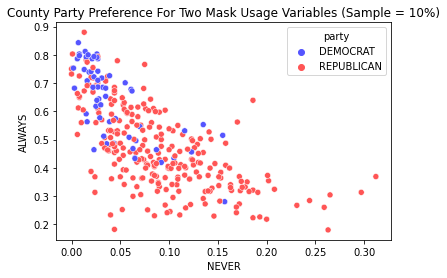

In [117]:
# Small sample of counties and their actual political preference plotted against two extreme mask usage variables.
sns.scatterplot(data = county_data_party[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'party']].sample(frac=0.1, random_state=42),
               x = 'NEVER',
               y = 'ALWAYS',
               hue = 'party', palette='seismic', hue_order=['DEMOCRAT', 'REPUBLICAN']);
plt.title('County Party Preference For Two Mask Usage Variables (Sample = 10%)');

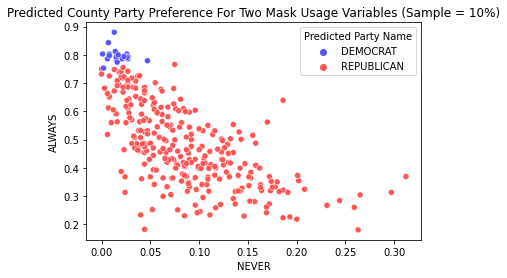

In [118]:
# Small sample of counties and their predicted political preference plotted against two extreme mask usage variables.
sns.scatterplot(data = county_data_party[['NEVER', 'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'Predicted Party Name']].sample(frac=0.1, random_state=42),
               x = 'NEVER',
               y = 'ALWAYS',
               hue = 'Predicted Party Name', palette='seismic', hue_order=['DEMOCRAT', 'REPUBLICAN']);
plt.title('Predicted County Party Preference For Two Mask Usage Variables (Sample = 10%)');

<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

In [119]:
#Predict cases per capita on 9/1/21 using all past COVID case data available (before 9/1).

dates_6a = county_data_party.loc[:,'1/22/20':'9/1/21'].columns
X_6a = county_data_party[np.append(dates,'Predicted Party')].drop('9/1/21', axis=1)
y_6a = county_data_party['9/1/21']

X_6a_train, X_6a_test, y_6a_train, y_6a_test = train_test_split(X_6a, y_6a, test_size=0.33, random_state=42)
model_6a = LinearRegression()
model_6a.fit(X_6a_train, y_6a_train)

train_6a_rmse = np.sqrt(np.mean((model_6a.predict(X_6a_train) - y_6a_train)**2))
test_6a_rmse = np.sqrt(np.mean((model_6a.predict(X_6a_test) - y_6a_test)**2))

train_6a_rmse, test_6a_rmse

(0.0002572961008264298, 6.3805125918444645)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

In [134]:
#Improve through feature engineering. Using only past two weeks of COVID data.

dates_6b = county_data_party.loc[:,'8/18/21':'9/1/21'].columns
X_6b = county_data_party[np.append(dates_6b,'Predicted Party')].drop('9/1/21', axis=1)
y_6b = county_data_party['9/1/21']

X_6b_train, X_6b_test, y_6b_train, y_6b_test = train_test_split(X_6b, y_6b, test_size=0.33, random_state=42)
model_6b = LinearRegression()
model_6b.fit(X_6b_train, y_6b_train)

train_6b_rmse = np.sqrt(np.mean((model_6b.predict(X_6b_train) - y_6b_train)**2))
test_6b_rmse = np.sqrt(np.mean((model_6b.predict(X_6b_test) - y_6b_test)**2))

train_6b_rmse, test_6b_rmse

(0.0008252846003563106, 0.0008592149682457161)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

In [121]:
...

Ellipsis

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

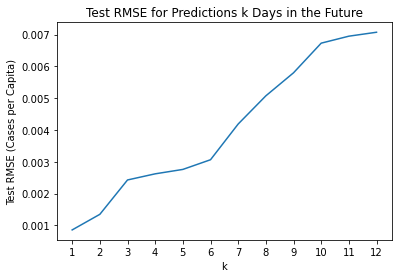

In [122]:
#Essentially answering 6e
k_dates = county_data_party.loc[:,'9/1/21':'9/12/21'].columns
model_6a_errors = []
model_6b_errors = []
for date in k_dates:
    y_6a = county_data_party[date]
    y_6b = county_data_party[date]
    X_6a_train, X_6a_test, y_6a_train, y_6a_test = train_test_split(X_6a, y_6a, test_size=0.33, random_state=42)
    X_6b_train, X_6b_test, y_6b_train, y_6b_test = train_test_split(X_6b, y_6b, test_size=0.33, random_state=42)
    
    test_6a_rmse = np.sqrt(np.mean((model_6a.predict(X_6a_test) - y_6a_test)**2))
    model_6a_errors.append(test_6a_rmse)
    test_6b_rmse = np.sqrt(np.mean((model_6b.predict(X_6b_test) - y_6b_test)**2))
    model_6b_errors.append(test_6b_rmse)

plt.plot(model_6b_errors)
plt.ylabel('Test RMSE (Cases per Capita)')
plt.xlabel('k')
plt.title('Test RMSE for Predictions k Days in the Future');
plt.xticks(np.arange(0,12), np.arange(1,13));

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

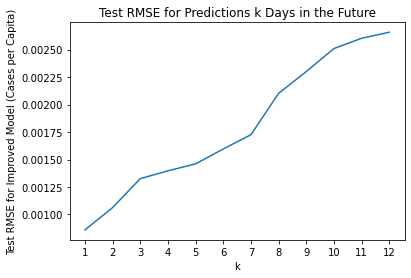

In [123]:
#Another improved model that does a better job of predicted cases k days in the future in one shot.
dates_6f = county_data_party.loc[:,'8/18/21':'9/1/21'].columns
X_6f = county_data_party[np.append(dates_6f,'Predicted Party')].drop('9/1/21', axis=1)
y_6f = county_data_party.loc[:, '9/1/21':'9/12/21']

X_6f_train, X_6f_test, y_6f_train, y_6f_test = train_test_split(X_6f, y_6f, test_size=0.33, random_state=42)
model_6f = LinearRegression()
model_6f.fit(X_6f_train, y_6f_train)

train_6f_rmse = np.sqrt(np.mean((model_6f.predict(X_6f_train) - y_6f_train)**2))
test_6f_rmse = np.sqrt(np.mean((model_6f.predict(X_6f_test) - y_6f_test)**2))

test_6f_rmse.values

plt.plot(test_6f_rmse.values)
plt.ylabel('Test RMSE for Improved Model (Cases per Capita)')
plt.xlabel('k')
plt.title('Test RMSE for Predictions k Days in the Future');
plt.xticks(np.arange(0,12), np.arange(1,13));

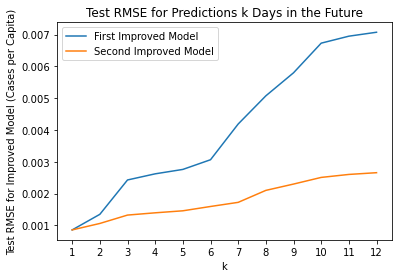

In [124]:
#Both improved models and their Errors for predictions k days in the future.
plt.plot(model_6b_errors, label='First Improved Model')
plt.plot(test_6f_rmse.values, label = 'Second Improved Model')
plt.xticks(np.arange(0,12), np.arange(1,13));
plt.legend();
plt.ylabel('Test RMSE for Improved Model (Cases per Capita)')
plt.xlabel('k')
plt.title('Test RMSE for Predictions k Days in the Future');

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [125]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [126]:
# Save your notebook first, then run this cell to export your submission.
grader.export()